<a href="https://colab.research.google.com/github/jackie-Gung/Colab_ESAA/blob/main/2022_05_30_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **09. 회귀 실습 - 자전거 대여 수요 예측**
---
### **| 개요**
- **데이터 설명**
      1. datatime: hourly date + timestamp
      2. season: 1=spring, 2=summer, 3= autumn, 4: winter
      3. holiday: 1=주말을 제외한 국경일 등의 휴일, 0=주말 및 휴일
      4. workingday: 1=주말 및 휴일이 아닌 주중, 0=주말 및 휴일
      5. weather
        1) 1= 맑음, 약간 구름 낀 흐림
        2) 2= 안개, 안개 + 흐림
        3) 3= 가벼운 눈, 가벼운 비 + 천둥
        4) 4= 심함 눈/비, 천둥/번개
      6. temp: 온도(섭씨)
      7. atemp: 체감온도(섭씨)
      8. humidity: 상대습도
      9. windspeed: 풍속
      10. casual: 사전에 등록되지 않는 사용자가 대여한 횟수
      11. registered: 사전에 등록된 사용자가 대여한 횟수
      12. count: 대여 횟수

### **| 데이터 클렌징 및 가공**

In [1]:
# 필요한 라이브러리
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [2]:
# 데이터 가져오기
bike_df = pd.read_csv('/content/drive/MyDrive/bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
# 데이터 칼럼의 타입 살펴보기
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


- 10886개의 row 데이터 중에서 null값은 없으며, 대부분의 칼럼이 int or float형인데, datetime만 object형
- datetime: 년-월-일 시:분:초 문자 형식으로 되어 있음
- datetime을 년도,월,일,시간으로 총 4개 속성으로 분리하기 
  - 편하게 변환하려면 문자열->datetime 타입으로 변경하기
  - apply(pd.to_datetime)

In [4]:
# 문자열을 datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x: x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x: x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x: x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [5]:
# datetime 칼럼 삭제, count = casual+registered이므로 count만 남겨놓기
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

- RMSLE(Root Mean Squared Log Error)
- 사이킷런은 rmsle을 제공하지 않으므로 rmsle를 수행하는 성능 평가 함수를 직접 만들어보기

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log값 변환 시 NaN 등의 이유로 log()가 아닌 log1p()을 이용해 RMSLE 계산하기
def rmsle(y,pred): 
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred)**2
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle

# 사이킷런의 mean_squared_error()를 이용해 RMSLE 계산하기
def rmse(y,pred):
  return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 모두 계산하기
def evaluate_regr(y,pred):
  rmsle_val = rmsle(y,pred)
  rmse_val = rmse(y,pred)
  # MAE는 사이킷런의 mean_absolute_error()로 계산하기
  mae_val = mean_absolute_error(y,pred)
  print('RMSLE: {0:.3f}, RMSE: {1:.3f}, MAE: {2:.3f}'.format(rmsle_val,rmse_val,mae_val))

- rmsle 구할 때 넘파이의 log()나 사이킷런의 mean_squared_error()를 사용할 수도 있지만 데이터 크기에 따라 오버플로/언더플로 오류가 발생할 수 있음

### **| 로그 변환, 피처 인코딩과 모델 학습/예측/평가**
- 회귀 모델을 이용해 자전거 대여 횟수 측정해보기
- 데이터 세트에 대해 처리해야 할 사항
  1. 결과값이 정규 분포인지 확인
  2. 카테고리형 회귀 모델인 경우, 원핫 인코딩으로 피처 인코딩


In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1, inplace=False)
X_train,X_test,y_train,y_test = train_test_split(X_features,y_target,
                                                 test_size=0.3,random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_features,y_target)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test,pred)

RMSLE: 1.163, RMSE: 140.713, MAE: 105.723


- **결과**
      1. RMSLE: 1.163, RMSE: 140.713, MAE: 105.723는 실제 Target 데이터 값인 대여 횟수를 감안하면 예측 오류로서는 비교적 큰 값임

- 실제 값과 예측값이 어느 정도 차이가 나는지 dataframe의 칼럼으로 만들어서 오류 값이 가장 큰 순으로 5개만 확인해보기

In [8]:
def get_top_error_data(y_test,pred,n_tops=5):
  # dataframe의 칼럼으로 실제 대여 횟수와 예측값을 서로 비교할 수 있도록 생성하기
  result_df = pd.DataFrame(y_test.values, columns=['real_count'])
  result_df['predicted count'] = np.round(pred)
  result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted count'])

  # 예측값과 실제 값이 가장 큰 데이터 순으로 출력하기
  print(result_df.sort_values('diff',ascending=False)[:n_tops])

get_top_error_data(y_test,pred,n_tops=5)


      real_count  predicted count   diff
1618         890            323.0  567.0
966          884            324.0  560.0
412          745            192.0  553.0
3151         798            245.0  553.0
2277         813            268.0  545.0


- **결과**
      1. 가장 큰 상위 5위 오류 값은 545~567로 실제 값을 감안하면 예측 오류가 꽤 큼
      2. 회귀에서 이러한 큰 예측 오류가 발생할 경우, 가장 먼저 살펴볼 것은 target 값의 분포가 왜곡된 형태를 이루고 있는지 확인해보기
      3. target 값의 분포는 정규 분포 형태가 가장 좋아서, 그렇지 않으면 회귀 예측 성능이 저하되는 경우가 많음

- 판다스의 DataFrame의 hist()를 이용해 자전거 대여 모델의 target 값인 count 칼럼이 정규 분포를 이루는지 확인해보기

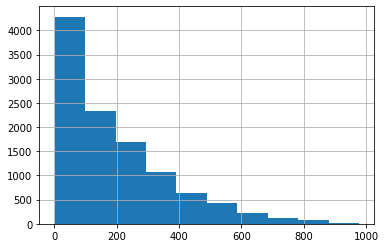

In [9]:
y_target.hist()

- **결과**
      1. count 칼럼은 정규 분포 형태가 아닌 0~200 사이에 왜곡돼있는 것을 알 수 있음
      2. 이렇게 왜곡된 값을 정규 분포 형태로 바꾸는 가장 대표적인 방법은 로그 변환임
        - log1p()
        - expm1()

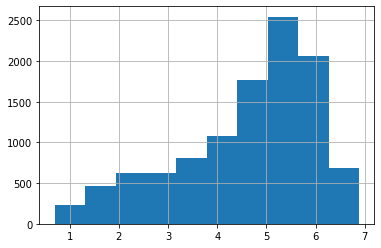

In [10]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

- 원하는 정규 분포 형태는 아니지만 이전보다 왜곡 정도가 많이 향상됨
- 다시 학습한 후에 평가를 수행해보기

In [11]:
# 타깃 칼럼인 count 값을 log1p로 로그 변환하기
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 세트 분할하기
X_train,X_test,y_train,y_test = train_test_split(X_features,y_target_log,
                                                 test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 세트의 target 값은 로그 변환됐으므로 다시 expm1을 이용해 원래 스케일로 변환하기
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타깃 기반으로 학습돼 예측됐으므로 다시 expm1로 스케일 변환하기
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp,pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


- **결과**
      1. RMSLE 오류는 줄었지만 RMSE는 오히려 늘어남

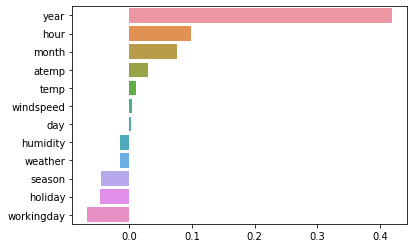

In [12]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

- **결과**
        1. year 피처의 회귀 계수 값이 독보적으로 큰 값을 가지고 있음
        2. year는 2011,2012년 두 개의 값으로 돼 있으므로 year에 따라서 자전거 대여 횟수가 크게 영향을 받는다는 것은 납득하기 어려움
        3. year는 카테고리형 피처지만 숫자형 값으로 되어 있고, 심지어 숫자가 2011,2012로 매우 큼
        4. 사이킷런은 카테고리만을 위한 데이터 타입이 없으며, 모두 숫자로 변환해야함
        5. 숫자형 카테고리 값을 선형 회귀에 사용할 경우, 회귀 계수를 연산할 때 이 숫자형 값에 크게 영향을 받는 경우가 발생할 수 있음
        6. 따라서 선형 회귀에서는 피처 인코딩에 원핫 인코딩을 적용해서 변환해야 함

In [13]:
# year, month, day, hour 등 피처를 one-hot encoding하기
X_features_ohe = pd.get_dummies(X_features, columns=['year','month','day','hour','holiday','workingday','season','weather'])

- 사이킷런으 선형 회귀 모델인 LinearRegression, Ridge, Lasso를 모두 학습해 예측 성능 확인해보기
- get_model_predict()

In [14]:
# 원핫 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할하기
X_train,X_test,y_train,y_test = train_test_split(X_features_ohe, y_target_log,
                                                 test_size=0.3, random_state=0)

# 모델 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환하기
def get_model_predict(model,X_train,X_test,y_train,y_test, is_expm1=False):
  model.fit(X_train,y_train)
  pred = model.predict(X_test)
  if is_expm1:
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)
  print('###', model.__class__.__name__, '###')
  evaluate_regr(y_test,pred)
# end of function get_model_predict

# 모델별로 평가 수행하기
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
  get_model_predict(model,X_train,X_test,y_train,y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


- **결과**
      1. 원핫 인코딩 적용 후에 선형 회귀의 예측 성능이 많이 향상됨

- 원핫 인코딩된 데이터 세트에서 회귀 계수가 높은 피처를 다시 시각화하기
  - 상위 25개 피처 추출하기

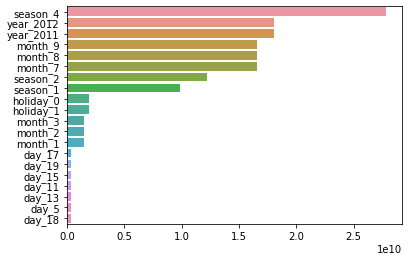

In [15]:
coef = pd.Series(lr_reg.coef_, index = X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

- **결과**
      1. 선형 회귀 모델 시 month_9,month_8,month_7등의 월 관련 피처들과 workingday 관련 피처들, 그리고 hour 관련 피처들의 회귀 계수가 높은 것을 알 수 있음
      2. 월, 주말/주중, 그리고 시간대 등 상식선에서 자전거를 타는 데 필요한 피처의 회귀 계수가 높아짐
      3. 피처를 어떻게 인코딩하는지가 선형 회귀 수행할 때 얼마나 중요한지 알 수 있음

- 회귀 트리를 이용해 회귀 예측을 수행하기
  - 랜덤 포레스트, GBM, XGBoost, LightGBM
  - XGBoost 경우에는 버젼에 따라 오류가 발생할 수 있으므로 학습/테스트 데이터를 dataframe의 values 속성을 이용해 넘파이 ndarray로 변환하기

In [16]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model별로 평가 수행하기
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in (rf_reg,gbm_reg,xgb_reg,lgbm_reg):
  get_model_predict(model,X_train.values,X_test.values,y_train.values,
                    y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.355, RMSE: 50.199, MAE: 31.087
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.353, MAE: 32.747
[00:58:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMSLE: 0.345, RMSE: 58.245, MAE: 35.768
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


- **결과**
      1. 앞의 선형 회귀 모델보다 회귀 예측 성능이 개선됨
      2. 하지만 이것이 회귀 트리가 선형 회귀보다 더 나은 성능을 가진다는 의미는 아님
      3. 데이터 세트의 유형에 따라 결과는 얼마든지 달라질 수 있음

## **10. 회귀 실습 - 캐글 주택 가격: 고급 회귀 기법**
---
### **| 개요**
- **데이터 설명**
      1. 79개의 변수로 구성됨
      2. 미국 아이와 주의 에임스 지방으 ㅣ주택 가격 정보를 가짐
      3. RMSLE를 기반으로 함
      4. 가격이 비싼 주택일수록 예측 결과 오류가 전체 오류에 미치는 비중이 높으므로 이것을 상쇄하기 위해 오류 값을 로그 변환한 RMSLE 를 이용함


In [17]:
# 데이터 사전 처리
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [18]:
house_df_org = pd.read_csv('/content/drive/MyDrive/house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [19]:
print('Shape: ', house_df.shape)
print('\n전체 피처 type\n', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nnull 칼럼과 그 건수: \n', isnull_series[isnull_series > 0].sort_values(ascending=False))

Shape:  (1460, 81)

전체 피처 type
 object     43
int64      35
float64     3
dtype: int64

null 칼럼과 그 건수: 
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


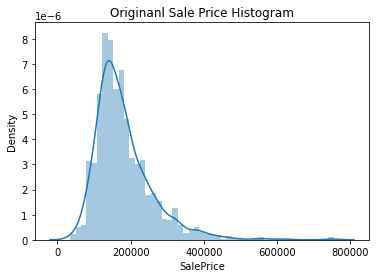

In [20]:
# 타깃 값의 분포가 정규 분포인지 확인하기
plt.title('Originanl Sale Price Histogram')
sns.distplot(house_df['SalePrice'])

- 데이터 값의 분포가 왼쪽으로 치우친 형태로, 정규 분포에서 벗어나 있음
- 이를 해결하기 위해 로그 변환해야함

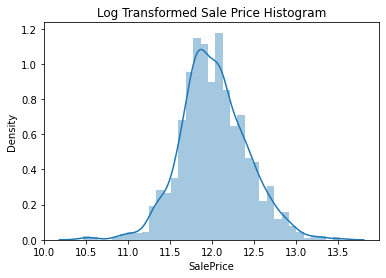

In [21]:
plt.title('Log Transformed Sale Price Histogram')
log_Sale_Price = np.log1p(house_df['SalePrice'])
sns.distplot(log_Sale_Price)

- SalePrice를 로그 변환한 뒤 DataFrame에 반영하기
- null 값이 많은 피처인 PoolQC, MiscFeature, Alley, Fence, FireplaceQu는 삭제하기
- id도 단순 식별자이므로 삭제하기
- LotFrontage는 null갑싱 259개로 비교적 많지만 평균값으로 대체하기
- 나머지 null 피처는 null 값이 많지 않으므로 숫자형의 경우에는 평균값으로 대체하기
- DataFrame 객체의 mean() 메서드
  - 자동으로 숫자형 칼럼만 추출해 칼럼별 평균값을 Series 객체로 반환해줌

In [22]:
# SalePrice 로그 변환하기
original_saleprice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# null 값이 많은 칼럼과 불필요한 칼럼 삭제하기
house_df.drop(['Id', 'MiscFeature','Alley','Fence','FireplaceQu'],axis=1, inplace=True)

# 드롭하지 않은 숫자형 null 칼럼은 평균값으로 대체하기
house_df.fillna(house_df.mean(), inplace=True)

# null 값이 피처명과 타입을 추출하기
null_column_count = house_df.isnull().sum()[house_df.isnull().sum()>0]
print('## null 피처의 type: \n', house_df.dtypes[null_column_count.index])

## null 피처의 type: 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
PoolQC          object
dtype: object


- **결과**
       문자형 피처를 제외하고는 NULL값이 없음

- 문자형 피처를 모두 원핫 인코딩으로 변환하기
- get_dummies()
  - 자동으로 문자열 피처를 원핫 인코딩으로 변환
  - null 값은 none 칼럼으로 대체하기 때문에 별도의 null 값을 대체하는 로직이 필요 없음
  - 원핫 인코딩을 적용하면 칼럼이 당연히 증가함
  - 칼럼이 얼마나 늘었는지 확인해보기

In [23]:
print('get_dummies() 수행 전 데이터 shape: ', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 shape', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
print('## null 피처의 type: \n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 shape:  (1460, 76)
get_dummies() 수행 후 데이터 shape (1460, 274)
## null 피처의 type: 
 Series([], dtype: object)


- **결과**
      1. 원핫 인코딩 이후에 피처가 76->274로 증가함
      2. null 값을 가진 피처는 존재하지 않음

- 회귀 모델을 생성해 학습한 후 예측 결과를 평가해보기
  1. LinearRegression()
  2. Ridge()
  3. Lasso()

### **| 선형 회귀 모델 학습/예측/평가**
- 앞에서 예측한 평가는 RMSLE(실제 값과 예측 값의 오류를 로그 변환한 뒤 RMSE 적용)를 이용함
- 그런데 이미 타깃 값인 SalePrice는 로그 변환됨
- 예측값 역시 로그 변환된 SalePrice 값을 기반으로 예측하므로 원본 SalePrice 예측값의 로그 변환 값임
- 실제 값과 예측 값 모두 로그 변환값이므로 예측 결과 오류에 RMSE만 적용하면 RMSLE가 자동으로 측정됨


In [24]:
def get_rmse(model):
  pred = model.predict(X_test)
  mse = mean_squared_error(y_test,pred)
  rmse = np.sqrt(mse)
  print(model.__class__.__name__, '로그 변환된 RMSE: ', np.round(rmse,3))
  return rmse

def get_rmses(models):
  rmses = []
  for model in models:
    rmse = get_rmse(model)
    rmses.append(rmse)
  return rmses

In [25]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1,inplace=False)
X_train,X_test,y_train,y_test = train_test_split(X_features,y_target,test_size=0.2,random_state=156)

# LR, Ridge, Lasso 학습/예측/평가하기
lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train,y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train,y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE:  0.131
Ridge 로그 변환된 RMSE:  0.128
Lasso 로그 변환된 RMSE:  0.176


[0.13114972440648007, 0.12833971915616663, 0.17628250556471403]

- **결과**
      1. 라쏘 회귀의 경우, 회귀 성능이 타 성능보다 많이 떨어지는 결과가 나옴
      2. 라쏘의 경우, 최적 하이퍼 파라미터 튜닝이 필요해보임

- 피처별 회귀 계수를 시각화해서 모델별로 어떤 피처의 회귀 계수로 구성되는지 확인해보기
- 피처 수가 많기 때문에 회귀 계수 상위 10개, 하위 10개의 피처명과 그 회귀 계수 값을 가지는 판다스 Series 객체 반환하는 함수 만들기

In [26]:
def get_top_bottom_coef(model, n=10):
  # coef_ 속성을 기반으로 Series 객체를 생성, index는 칼럼명으로 설정하기
  coef = pd.Series(model.coef_, index=X_features.columns)

  # 상하위 각각 10개의 회귀 계수 추출해서 반환하기
  coef_high = coef.sort_values(ascending=False).head(n)
  coef_low = coef.sort_values(ascending=False).tail(n)
  return coef_high, coef_low

- visualize_coefficient(models)
  - list 객체로 모델을 입력 받아 모델별로 회귀 계수를 추출해 가로 막대 그래프 형태로 출력

In [27]:
def visualize_coefficient(modles):
  # 3개 회귀 모델의 시각화를 위해 3개 칼럼을 가지는 subplot 생성하기
  fig,axs = plt.subplots(figsize=(24,10), nrows=1,ncols=3)
  fig.tight_layout()

  # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화하기
  for i_num, model in enumerate(models):
    # 상하위 각 10개 회귀 곗수를 구하고, 이를 판다스 concat으로 결합하기
    coef_high, coef_low = get_top_bottom_coef(model)
    coef_concat = pd.concat([coef_high, coef_low])

    # ax subplot에 barchar로 표현, 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정하기
    axs[i_num].set_title(model.__class__.__name__+'Coeffiecents',size=25)
    axs[i_num].tick_params(axis='y', direction='in', pad=120)
    for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
      label.set_fontsize(22)
    sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

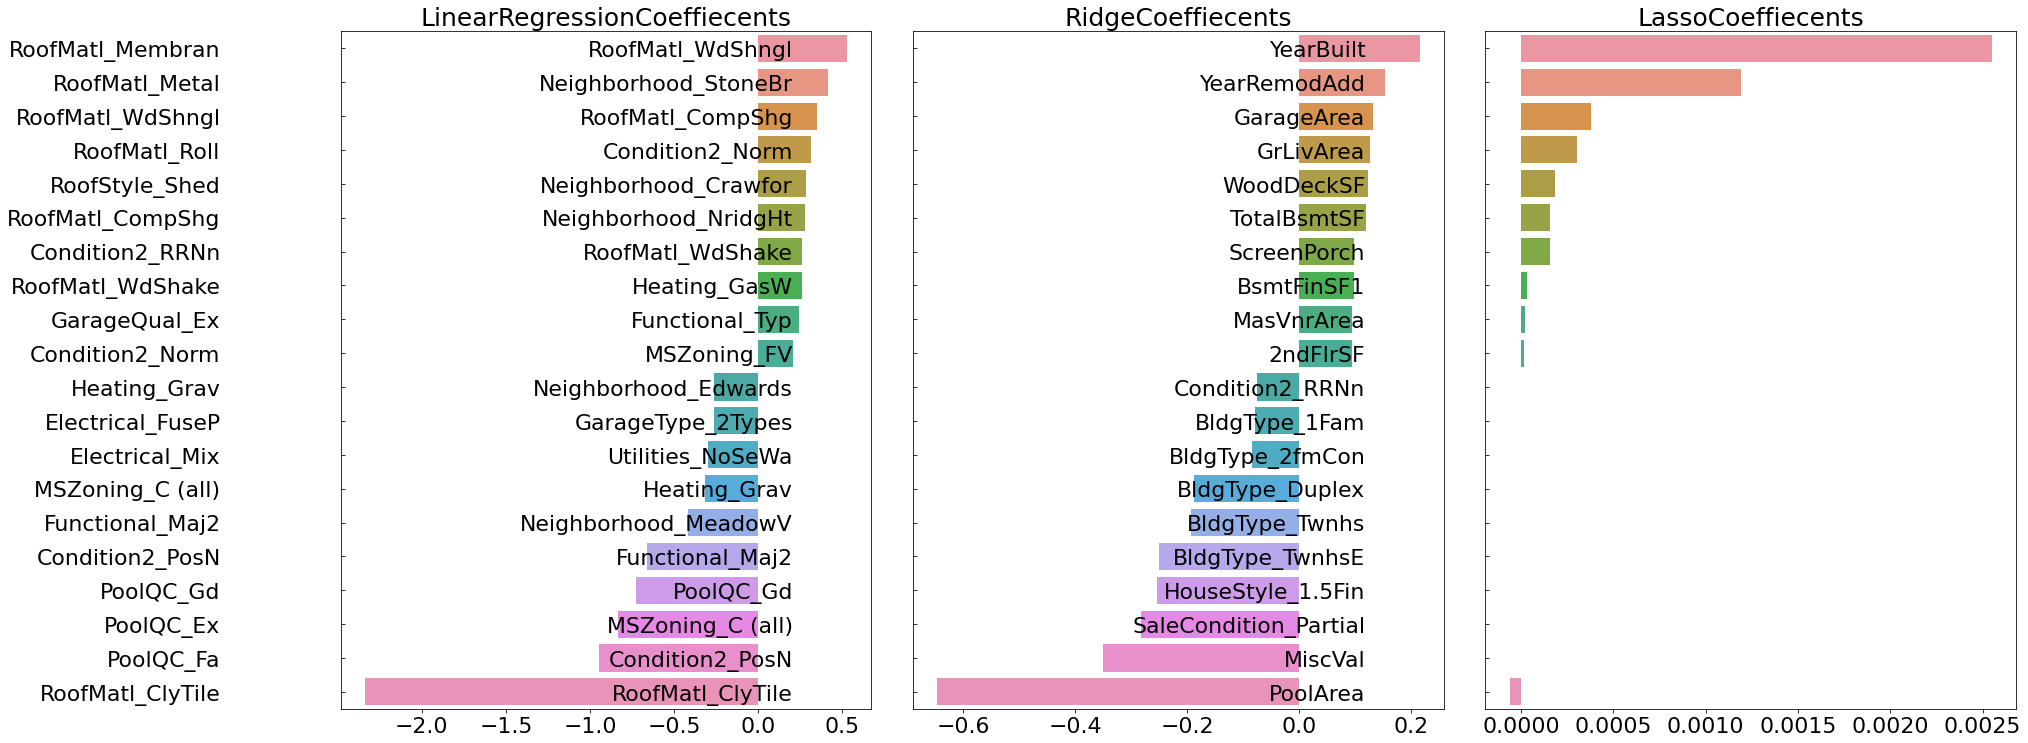

In [28]:
models = [lr_reg,ridge_reg,lasso_reg]
visualize_coefficient(models)

- **결과**
      1. 모델별 회귀 계수를 보면, OLS 기반의 LR, Ridge 경우에는 회귀 계수가 유사한 형태로 분포되어 있음
      2. 하지만 라쏘는 전체적으로 회귀 계수 값이 매우 작고, 그중에 YearBuilt가 가장 크고, 나머지 피처의 계수들은 너무 작음
      3. 라쏘의 경우, 다른 두 모델과는 다른 형태를 보이고 있음
      4. 학습 데이터의 분할 문제가 있어서 그런 것인지 확인해볼 필요가 있음
        - train_test_split() X
        - cross_val_score(): 타깃과 피처를 5개 교차 검증 폴드 세트로 분할해 평균 RMSE 측정해보기

In [29]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
  for model in models:
    # 분할하지 않고 전체 데이터로 cross_val_score() 수행하기
    rmse_list = np.sqrt(-cross_val_score(model,X_features, y_target,
                                         scoring='neg_mean_squared_error',cv=5))
    rmse_avg = np.mean(rmse_list)
    print('\n{0} cv RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list,3)))
    print('{0} cv 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg,3)))

In [30]:
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression cv RMSE 값 리스트: [0.136 0.164 0.167 0.111 0.2  ]
LinearRegression cv 평균 RMSE 값: 0.156

Ridge cv RMSE 값 리스트: [0.116 0.154 0.142 0.117 0.19 ]
Ridge cv 평균 RMSE 값: 0.144

Lasso cv RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso cv 평균 RMSE 값: 0.198


- **결과**
      1. 5개 폴드 세트로 학습한 후에 수행한 평가에도 여전히 라쏘는 다른 두 회귀 모델보다 성능이 떨어짐
      2. alpha 하이퍼 파라미터를 변화시키면서 최적 값을 도출해보기

- print_best_params(model,params)
  - 모델과 하이퍼 파라미터 딕셔너리 객체를 받아 최적화 작업의 결과를 표시하는 함수

In [31]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model,params):
  grid_model = GridSearchCV(model, param_grid = params,
                            scoring='neg_mean_squared_error', cv=5)
  grid_model.fit(X_features,y_target)
  rmse = np.sqrt(-1 * grid_model.best_score_)
  print('{0} 5 cv 시 최적 평균 RMSE 값: {1}, 최적 alpha: {2}'.format(model.__class__.__name__,
                                                             np.round(rmse,4),grid_model.best_params_))
  
ridge_params = {'alpha': [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha': [0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 cv 시 최적 평균 RMSE 값: 0.1417, 최적 alpha: {'alpha': 10}
Lasso 5 cv 시 최적 평균 RMSE 값: 0.142, 최적 alpha: {'alpha': 0.001}


- **결과**
      1. 릿지의 경우, alpha=10일 때 최적 평균 RMSE가 0.1417로, 라쏘의 경우 alpha=0.001일 때 최적 평균 RMSE가 0.142
      2. 라쏘 모델은 alpha 값 최적화 이후 예측 성능이 전보다 많이 좋아짐

- 선형 모델에 최적 alpha 값을 설정한 뒤, train_test_split()으로 분할된 학습 데이터와 테스트 데이터를 이용해 모델의 학습/예측/평가를 수행하고 모델별 회귀 계수를 시각화해보기

LinearRegression 로그 변환된 RMSE:  0.131
Ridge 로그 변환된 RMSE:  0.124
Lasso 로그 변환된 RMSE:  0.12


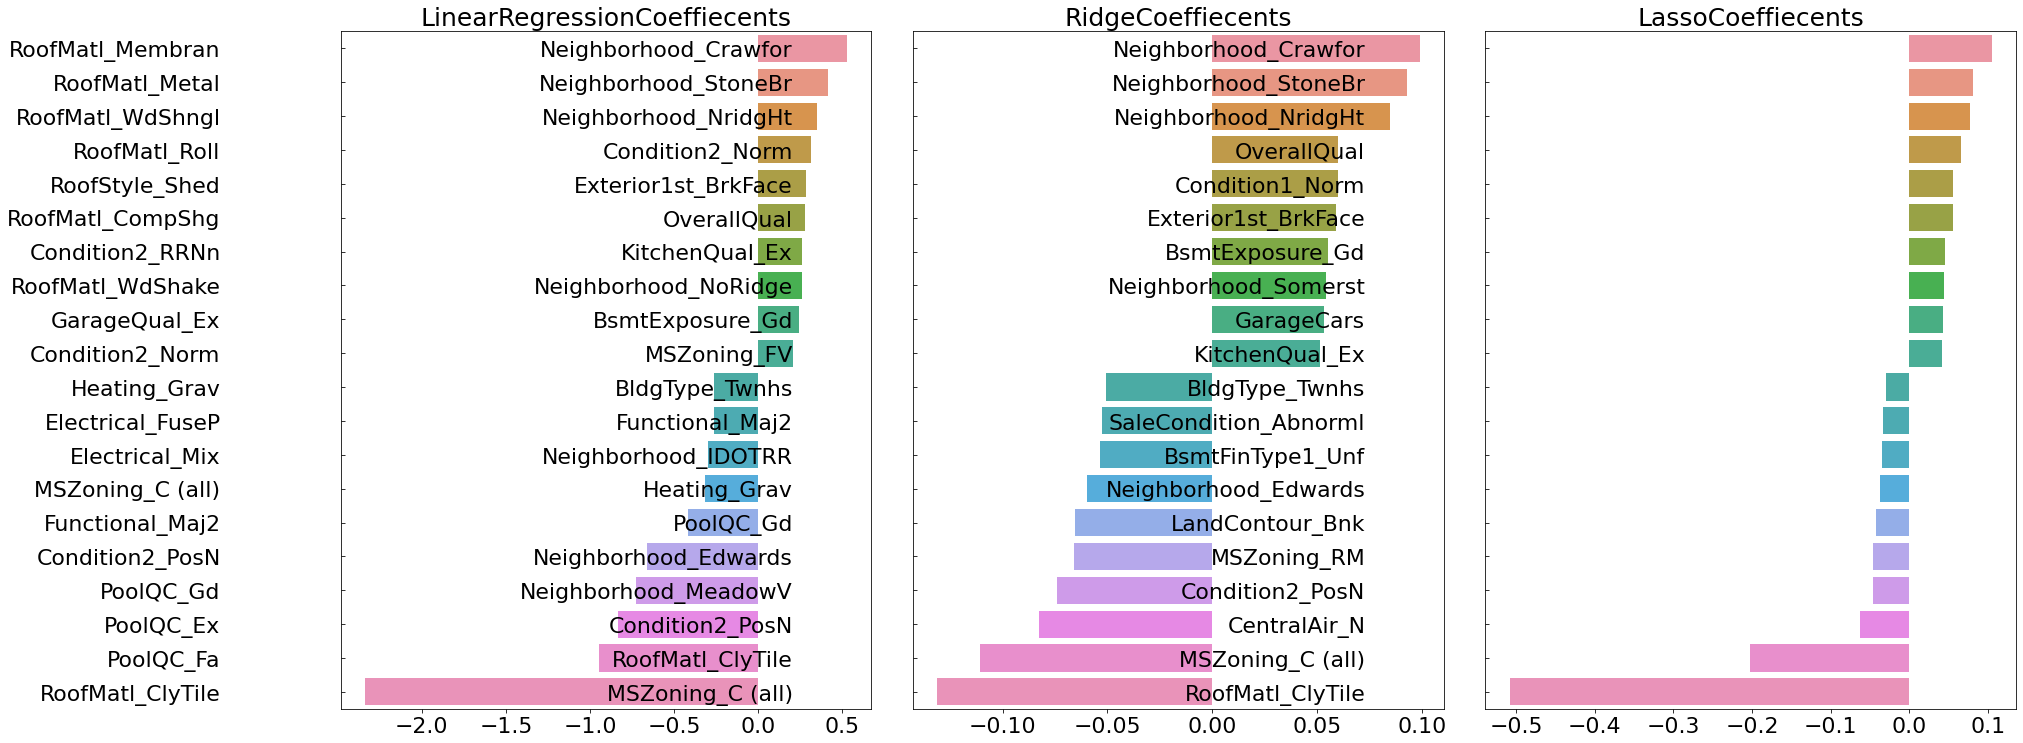

In [32]:
lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train,y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train,y_train)

# 모든 모델의 RMSE 출력하기
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화하기
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- **결과**
      1. alpha 값 최적한 후 테스트 데이터 세트의 예측 성능이 더 좋아짐
      2. 모델별 회귀 계수도 많이 달라짐
      3. 기존에는 라쏘 모델의 회귀 계수가 다른 두 모델과 많은 차이를 보였ㅇ나, 이번에는 릿지와 라쏘 모델에서 비슷한 피처의 회귀 계수가 높음
      4. 다만 라쏘 모델의 경우, 릿지에 비해 동일한 피처라도 회귀 계수 값이 상당히 작음

- **데이터 세트를 추가적으로 가공해서 모델 튜닝을 더 진행해보기**
      1. 피처 데이터 세트의 데이터 분포도
      2. 이상치 데이터 처리

#### **1) 피처 데이터 세트의 데이터 분포도**
- 피처 데이터 세트도 지나치게 왜곡된 피처가 존재할 경우에 회귀 예측 성능을 저하시킬 수 있음
- 모든 숫자형 피처 데이터 분포도를 확인하여 분포도가 어느 정도로 왜곡됐는지 알아보기
- 사이파이  stats 모듈의 skew() 함수
  -  skew() 함수의 반환 값이 1 이상이면 왜곡 정도가 높다고 판단하지만, 상황에 따라 편차는 존재
  -  1 이상의 값을 반환하는 피처만 추출해 왜곡 정도를 완화하기 위한 로그 변환을 적용하기
  - 주의할 점: skew()적용하는 숫자형 피처에서 원핫 인코딩된 카테고리 숫자형 피처는 제외해야함
  - 카테고리 피처는 코드성 피처이므로 인코딩 시 당연히 왜곡될 가능성이 높음

In [33]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출하기
features_index = house_df.dtypes[house_df.dtypes != 'object'].index

# house_df에 칼럼 index를 []로 입력하면 해당되는 칼럼 데이터 세트를 반환함 -> apply lambda로 skew 호출하기
skew_features = house_df[features_index].apply(lambda x: skew(x))

# skew 정도가 1 이상인 칼럼만 추출하기
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [34]:
# 추출된 왜곡 정도가 높은 피처를 로그 변환하기
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

- **결과**
      1. 로그 변환 후 피처들의 왜곡 정도를 다시 확인해 보면, 여전히 높은 왜곡 정도를 가진 피처가 존재하지만, 더 이상 로그 변환을 하더라도 개선하기는 어렵기에 그대로 유지하기

- 원핫 인코딩을 다시 적용해서 학습/테스트 데이터 세트를 다시 만든 후에 최적 alpha값과 RMSE를 다시 구해보기

In [35]:
# 왜곡 정도가 높은 피처를 로그 변환함 -> 다시 원핫 인코딩을 적용하고 피처/타킷 데이터 세트 생성하기
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train,X_test, y_train,y_test = train_test_split(X_features, y_target,test_size=0.2,
                                                  random_state=156)

# 피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력하기
ridge_params = {'alpha': [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha': [0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 cv 시 최적 평균 RMSE 값: 0.1275, 최적 alpha: {'alpha': 10}
Lasso 5 cv 시 최적 평균 RMSE 값: 0.1252, 최적 alpha: {'alpha': 0.001}


- 결과
      1. 릿지와 라쏘 모델 모두 최적 alpha값이 동일함
      2. 피처 로그 변환 이전과 비교했을 때 릿지는 0.1417->0.1275, 라쏘는 0.142->0.1252로 5 폴드 교차 검증의 평균 RMSE 값이 향상함

#### **2) 이상치 데이터**
- 특히 회귀 계수가 높은 피처, 즉 예측에 많은 영향을 미친는 중요 피처의 이상치 데이터의 처리가 중요함
- 세 개 모델 모두에서 가장 큰 회귀 계수를 가지는 GrLivArea 피처의 데이터 분포 *확인하기*

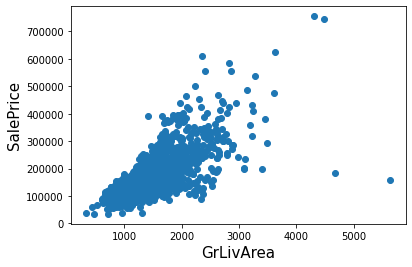

In [36]:
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

- 결과
      1. 일반적으로 주거 공간이 큰 집일수록 가격이 비싸기 때문에 GrLivArea 피처는 SalePrice와 양의 상관관계가 매우 높음
      2. x값이 5000인 주변에 2개의 점이 두 피처 관계에서 많이 어긋나 있음
      3. 공간이 4000 이상인데도 가격이 500,000달러 이하인 데이터는 모두 이상치로 간주하고 삭제하기

In [37]:
# GrLivArea와 SalePrice 모두 로그 변환됐으므로 이를 반영한 조건을 생성하기
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('outlier 레코드 index: ', outlier_index.values)
print('outlier 삭제 전 house_df_ohe shape: ', house_df_ohe.shape)

# DataFrame 인덱스를 이용해 이상치 레코드 삭제하기
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('outlier 삭제 후 house_df_ohe shape: ', house_df_ohe.shape)

outlier 레코드 index:  [ 523 1298]
outlier 삭제 전 house_df_ohe shape:  (1460, 274)
outlier 삭제 후 house_df_ohe shape:  (1458, 274)


- 결과
      1. 레코드 인덱스 523,1298이 대상이고, 두 개의 데이터를 삭제해 전체 레코드는 1460->1458로 줄었음

- 업데이트된 house_df_ohe를 기반으로 피처/타깃 데이터 세트를 다시 생성하고, 앞에서 정의한 print_best_params() 함수를 이용해 릿지와 라쏘 모델의 최적화를 수행하고 결과를 출력해보기

In [38]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train,X_test,y_train,y_test = train_test_split(X_features,y_target, test_size=0.2,random_state=156)

# 피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력하기
ridge_params = {'alpha': [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha': [0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 cv 시 최적 평균 RMSE 값: 0.1125, 최적 alpha: {'alpha': 8}
Lasso 5 cv 시 최적 평균 RMSE 값: 0.1122, 최적 alpha: {'alpha': 0.001}


- 결과
      1. 두 개의 이상치만 제거했는데 예측 수치가 매우 크게 향상됨
      2. 릿지 모델의 경우, alpha 값이 10->8로 변했고, RMSE가 0.1275->0.1125로 개선됨
      3. 라쏘 모델의 경우, 평균 RMSE가 0.1122로 개선됨-> 웬만큼 하이퍼 파라미터를 튜닝해도 이정도 개선되는 것은 어려움
      4. GrLivArea가 회귀 모델에서 차지하는 영향도가 크기에 이상치를 개선하는 것이 성능 개선에 큰 영향을 미친다는 것을 알 수 있음

### **| 회귀 트리 모델 학습/예측/평가**
- XGBoost: XGBRegressor
- LightGBM: LGBMRegressor
- 두 개 모두 수행 시간이 오래 걸리므로 하이퍼 파라미터 설정을 미리 한 뒤 5 폴드 세트에 대한 평균 RMSE 구해보기


In [39]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators': [1000]}
xgb_reg = XGBRegressor(n_estimators=1000,learning_rate=0.05,colsample_bytree=0.5,subsample=0.8)
print_best_params(xgb_reg,xgb_params)

[01:02:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:02:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:02:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:03:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:03:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor 5 cv 시 최적 평균 RMSE 값: 0.115, 최적 alpha: {'n_estimators': 1000}


- XGBoost 회귀 트리 적용했을 때 5 폴드 세트 평균 RMSE가 0.115

- LightGBM 회귀 트리 적용해보기

In [40]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators': [1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000,learning_rate=0.05,num_leaves=4,
                         subsample=0.6,colsample_bytree=0.4,reg_lambda=10,n_jobs=-1)
print_best_params(lgbm_reg,lgbm_params)

LGBMRegressor 5 cv 시 최적 평균 RMSE 값: 0.1161, 최적 alpha: {'n_estimators': 1000}


- LGBMRegressor 적용하면 5 폴드 세트 평균 RMSE가 약 0.1161임

### **| 회귀 모델의 예측 결과 혼합을 통한 최종 예측**
- 개별 회귀 모델의 예측 결과값을 혼합해 이를 기반으로 최종 회귀 값을 예측하기
- 예를 들어, 가령 A,B모델의 예측값이 있다면 A모델 예측값의 40%, B 모델 예측값의 60%를 더해서 최종 회귀 값으로 예측하기
- get_rmse_pred()

In [41]:
def get_rmse_pred(preds):
  for key in preds.keys():
    pred_value = preds[key]
    mse = mean_squared_error(y_test,pred_value)
    rmse = np.sqrt(mse)
    print('{0} 모델의 RMSE: {1}'.format(key,rmse))

In [43]:
# 개별 모델을 학습하기
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train,y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train,y_train)

# 개별 모델을 예측하기
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출하기
pred = 0.4*ridge_pred + 0.6*lasso_pred
preds = {'최종 혼합': pred,
         'Ridge' :ridge_pred ,
         'Lasso' : lasso_pred}

# 최종 혼합 모델, 개별 모델의 RMSE 값 출력하기
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10004190444202056
Ridge 모델의 RMSE: 0.10334034287788796
Lasso 모델의 RMSE: 0.10024170460890035


- 결과
      1. 최종 혼합 모델의 RMSE가 개별 모델보다 성능 면에서 약간 개선됨
      2. 릿지 모델 예측값에 0.4를 곱하고, 라쏘 모델 예측값에 0.6을 곱한 뒤 더함(비율은 특별한 기준이 없음)

- XGBoost와 LightGBM을 혼합해서 결과 살펴보기

In [46]:
xgb_reg = XGBRegressor(n_estimators=1000,learning_rate=0.05,colsample_bytree=0.5,subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000,learning_rate=0.05,num_leaves=4,
                        subsample=0.6,colsample_bytree=0.4,reg_lambda=10,n_jobs=-1)

xgb_reg.fit(X_train,y_train)
lgbm_reg.fit(X_train,y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5*xgb_pred + 0.5*lgbm_pred
preds={'최종 혼합': pred,
       'XGBM': xgb_pred,
       'LGBM': lgbm_pred}
get_rmse_pred(preds)

[01:48:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
최종 혼합 모델의 RMSE: 0.1002942989732536
XGBM 모델의 RMSE: 0.10398425500127395
LGBM 모델의 RMSE: 0.1015065721553885


### **| 스태킹 앙상블 모델을 통한 회귀 예측**
- 스태킹 모델에 필요한 모델
  - 개별적인 기반 모델
  - 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델

- 스태킹 모델의 핵시은 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용/테ㅡ트용 피처 데이터 세트를 만드는 것

In [49]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개발 기반 모델에서 최종 메탈 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수 만들기
def get_stacking_base_datasets(model,X_train_n,y_train_n,X_test_n,n_folds):
  # 지정된 n_folds값으로 KFold 생성하기
  kf = KFold(n_splits=n_folds,shuffle=True,random_state=0)

  # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화하기
  train_fold_pred = np.zeros((X_train_n.shape[0],1))
  test_pred = np.zeros((X_test_n.shape[0],n_folds))
  print(model.__class__.__name__,'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출하기
    print('\t 폴드 세트 : ',folder_counter,' 시작 ')
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    model.fit(X_tr,y_tr)
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
    test_pred[:,folder_counter] = model.predict(X_test_n)

  test_pred_mean = np.mean(test_pred,axis = 1).reshape(-1,1)

  return train_fold_pred,test_pred_mean

- get_stacking_base_datasets()
      1. 인자로 개별 기반 모델, 원래 사용되는 학습/테스트용 피처 데이터를 받음
      2. 함수 내에서는 개별 모델이 K-폴드 세트로 설정된 폴드 세트 내부에서 원본으 ㅣ학습 데이터를 다시 추출해 학습과 예측을 수행한 뒤 그 결과를 저장함
      3. 저장된 예측 데이터는 추후에 메타 모델의 학습 피처 데이터 세트로 이용됨
      4. 함수 내에서 폴드 세트 내부 학습 데이터로 학습된 개별 모델이 인자로 입력된 원본 테스트 데이터를 예측한 뒤, 예측 결과를 평균해 테스트 데이터로 생성함 

In [50]:
# get_stacking_base_datasets(): 넘파이 ndarray를 인자로 사용하므로 dataframe->ndarray로 바꾸기
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반 모델이 생성한 학습용/테스트용 데이터 반환하기
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg,X_train_n,y_train_n,X_test_n,5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg,X_train_n,y_train_n,X_test_n,5)
xgb_train,xgb_test = get_stacking_base_datasets(xgb_reg,X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg,X_train_n,y_train_n,X_test_n,5)

Ridge model 시작
	 폴드 세트 :  0  시작 
	 폴드 세트 :  1  시작 
	 폴드 세트 :  2  시작 
	 폴드 세트 :  3  시작 
	 폴드 세트 :  4  시작 
Lasso model 시작
	 폴드 세트 :  0  시작 
	 폴드 세트 :  1  시작 
	 폴드 세트 :  2  시작 
	 폴드 세트 :  3  시작 
	 폴드 세트 :  4  시작 
XGBRegressor model 시작
	 폴드 세트 :  0  시작 
[02:30:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트 :  1  시작 
[02:30:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트 :  2  시작 
[02:30:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트 :  3  시작 
[02:31:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트 :  4  시작 
[02:31:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
LGBMRegressor model 시작
	 폴드 세트 :  0  시작 
	 

- 각 개별 모델이 반환하는 학습용/테스트용 피처 데이터 세트를 결합해 최종 메타 모델에 적용해보기
- 메타 모델: Lasso
- 최종적으로 예측 및 RMSE 측정하기

In [51]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합하기
Stack_final_X_train = np.concatenate((ridge_train,lasso_train,xgb_train,lgbm_train),axis = 1)
Stack_final_X_test = np.concatenate((ridge_test,lasso_test,xgb_test,lgbm_test),axis = 1)

# 최종 메타 모델은 라쏘 모델로 적용하기
meta_model_lasso = Lasso(alpha = 0.0005)

# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측 및 RMSE 측정하기
meta_model_lasso.fit(Stack_final_X_train,y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test,final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE : ', rmse)

스태킹 회귀 모델의 최종 RMSE :  0.09807332027201196


- 최종적으로 스태킹 회귀 모델을 적용한 결과, 테스트 데이터 세트에서 RMSE가 0.098로 현재까지 가장 좋은 성능 평가를 보여줌
- 스태킹 모델은 분류뿐만 아니라 회귀에서 특히 효과적으로 사용될 수 있는 모델임